In [26]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import datetime
import math
import random
import matplotlib.pyplot as plt
import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
import logging
import time

from sklearn.metrics import confusion_matrix, classification_report, recall_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Preparation

In [27]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Create DataFrame for image paths and labels from dataset folder
def create_dataset_dataframe(dataset_path):
    image_paths = []
    labels = []
    
    # Get all class folders
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    
    for class_name in classes:
        class_folder = os.path.join(dataset_path, class_name)
        
        # Get all image files in the class folder
        for filename in os.listdir(class_folder):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                image_path = os.path.join(class_folder, filename)
                image_paths.append(image_path)
                labels.append(class_name)
    
    # Create DataFrame
    df = pd.DataFrame({
        'image': image_paths,
        'label': labels
    })
    
    return df

# Create the dataset DataFrame
dataset_path = '/kaggle/input/oip-danang-pest-detection'
df = create_dataset_dataframe(dataset_path)
df = df.replace(to_replace= r'\\', value= '/', regex=True)


print(f"Total images: {len(df)}")
print(f"Number of classes: {df['label'].nunique()}")
print(f"Classes: {sorted(df['label'].unique())}")
print("\nClass distribution:")
print(df['label'].value_counts())

# Split the data using sklearn train_test_split
train_data, test_data = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']  # Ensure balanced split across classes
)

print(f"\nTrain set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"\nTrain data sample:")
train_data.head()

Total images: 5494
Number of classes: 12
Classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']

Class distribution:
label
bees            500
snail           500
ants            499
wasp            498
moth            497
weevil          485
grasshopper     485
earwig          466
catterpillar    434
beetle          416
slug            391
earthworms      323
Name: count, dtype: int64

Train set size: 4395
Test set size: 1099

Train data sample:


,image,label
1015,/kaggle/input/oip-danang-pest-detection/earthw...,earthworms
4522,/kaggle/input/oip-danang-pest-detection/moth/m...,moth
4814,/kaggle/input/oip-danang-pest-detection/wasp/w...,wasp
1187,/kaggle/input/oip-danang-pest-detection/earthw...,earthworms
1287,/kaggle/input/oip-danang-pest-detection/ants/a...,ants


In [28]:
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, input_df, transform=None):
        self.input_df = input_df
        self.transform = transform
        self.class_to_idx = {label: idx for idx, label in enumerate(sorted(input_df['label'].unique()))}
        self.labels = input_df['label'].map(self.class_to_idx).values
        self.image_paths = input_df['image'].values

    def __len__(self):
        return len(self.input_df['label'])
    
    def idx_to_label(self, idx):
        return list(self.class_to_idx.keys())[list(self.class_to_idx.values()).index(idx)]

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load the image
        image = Image.open(image_path).convert('RGB')
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label
        

In [29]:
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

In [30]:
train_dataset = CustomDataset(train_data, transform=test_transform)
test_dataset = CustomDataset(test_data, transform=test_transform)

# Build Dataloader
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


torch.Size([3, 224, 224])


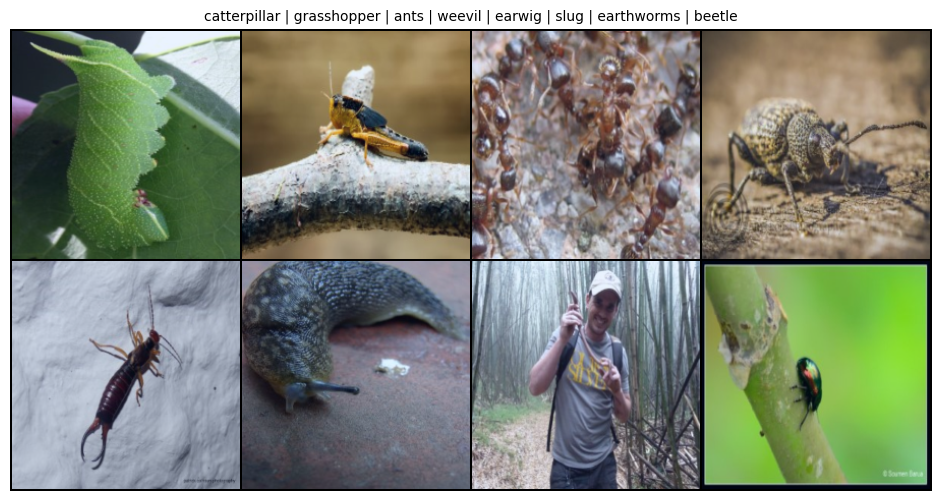

In [31]:
from torchvision.utils import make_grid

# Get batch
train_features, train_labels = next(iter(train_dataloader))

# Sample input dimensions so we know what is going in to the model
sample_input = train_features[0]
print(sample_input.shape)

# Create grid
grid = make_grid(train_features[:8], nrow=4, normalize=True)

label_names = [train_dataset.idx_to_label(label.item()) for label in train_labels[:8]]
title = " | ".join(label_names)

plt.figure(figsize=(12, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.title(title, fontsize=10)
plt.axis('off')
plt.show()

# Model

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DepthwiseSeparableConv(nn.Module):
    """Depthwise Separable Convolution - core of MobileNet efficiency"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        
        # Depthwise convolution
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=kernel_size, 
            stride=stride, padding=padding, groups=in_channels, bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        # Pointwise convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU6(inplace=True)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.pointwise(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

class InvertedResidual(nn.Module):
    """Inverted Residual Block with skip connection"""
    def __init__(self, in_channels, out_channels, stride=1, expand_ratio=6):
        super(InvertedResidual, self).__init__()
        
        self.stride = stride
        self.use_residual = stride == 1 and in_channels == out_channels
        
        hidden_dim = in_channels * expand_ratio
        
        layers = []
        
        # Expand
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True)
            ])
        
        # Depthwise + Pointwise
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=stride, 
                     padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        ])
        
        self.conv = nn.Sequential(*layers)
    
    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)

class CustomModel(nn.Module):
    def __init__(self, num_classes=12):
        super(CustomModel, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernal_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )
        
        # MobileNet blocks
        self.features = nn.Sequential(
            InvertedResidual(32, 16, 1, 1),      # 112x112
            InvertedResidual(16, 24, 2, 6),      # 56x56
            InvertedResidual(24, 24, 1, 6),      # 56x56
            InvertedResidual(24, 32, 2, 6),      # 28x28
            InvertedResidual(32, 32, 1, 6),      # 28x28
            InvertedResidual(32, 32, 1, 6),      # 28x28
            InvertedResidual(32, 64, 2, 6),      # 14x14
            InvertedResidual(64, 64, 1, 6),      # 14x14
            InvertedResidual(64, 64, 1, 6),      # 14x14
            InvertedResidual(64, 64, 1, 6),      # 14x14
            InvertedResidual(64, 96, 1, 6),      # 14x14
            InvertedResidual(96, 96, 1, 6),      # 14x14
            InvertedResidual(96, 96, 1, 6),      # 14x14
            InvertedResidual(96, 160, 2, 6),     # 7x7
            InvertedResidual(160, 160, 1, 6),    # 7x7
            InvertedResidual(160, 160, 1, 6),    # 7x7
            InvertedResidual(160, 320, 1, 6),    # 7x7
        )
        
        # Final convolution
        self.conv_last = nn.Sequential(
            nn.Conv2d(320, 1280, 1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Pooling
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1280, 512)
            nn.ReLU6(inplace=True)
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.features(x)
        x = self.conv_last(x)
        x = self.classifier(x)
        return x

In [34]:
# Create and initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel(num_classes=12).to(device)

In [35]:
# Test with sample input
sample_input = train_features.to(device) # Batch size 16
with torch.no_grad():
    output = model(sample_input)
    print(f"Output shape: {output.shape}")

Output shape: torch.Size([16, 12])


# Hyperparams

In [36]:
class LabelSmoothingCrossEntropy(nn.Module):
    """Label smoothing for better generalization"""
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
    
    def forward(self, x, target):
        confidence = 1. - self.smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# Hyperparameters
# Optimized hyperparameters
learning_rate = 0.001
num_epochs = 60
weight_decay = 0.05

# Enhanced optimizer
optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )

# Better scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=20, T_mult=2, eta_min=1e-6
    )

# Keep your label smoothing (good choice!)
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

In [37]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, learning_rate=0.001):
    """Advanced training function with multiple optimizations"""
    
    # Loss function - using label smoothing for better generalization
    criterion = criterion
    # Optimizer - AdamW with weight decay
    optimizer = optimizer
    # Learning rate scheduler - Cosine annealing with warm restarts
    scheduler = scheduler
    
    # Early stopping
    best_val_acc = 0.0
    patience = 15
    patience_counter = 0
    
    # Training history
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    print("Starting training...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct_train/total_train:.2f}%'
            })
        
        # Calculate training metrics
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct_train / total_train
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*correct_val/total_val:.2f}%'
                })
        
        # Calculate validation metrics
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * correct_val / total_val
        
        # Update learning rate
        scheduler.step()
        
        # Store metrics
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping and model saving
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies
            }, 'best_light_mobilenet_model.pth')
            print(f'  New best model saved! Val Acc: {best_val_acc:.2f}%')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
        
        print('-' * 60)
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

# Enhanced data augmentation for better generalization
enhanced_train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1)  # Random erasing for regularization
])

# Create enhanced datasets
train_dataset_enhanced = CustomDataset(train_data, transform=enhanced_train_transform)
val_dataset = CustomDataset(test_data, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset_enhanced, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Train the model
training_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs, learning_rate=learning_rate)

Starting training...


Epoch 1/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.27it/s, Loss=2.7107, Acc=16.56%]


Epoch 1/60:
  Train Loss: 2.4910, Train Acc: 13.45%
  Val Loss: 2.5166, Val Acc: 16.56%
  Learning Rate: 0.000994
  New best model saved! Val Acc: 16.56%
------------------------------------------------------------


Epoch 2/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.40it/s, Loss=2.3622, Acc=23.11%]


Epoch 2/60:
  Train Loss: 2.3473, Train Acc: 19.95%
  Val Loss: 2.4568, Val Acc: 23.11%
  Learning Rate: 0.000976
  New best model saved! Val Acc: 23.11%
------------------------------------------------------------


Epoch 3/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.34it/s, Loss=2.1806, Acc=30.12%]


Epoch 3/60:
  Train Loss: 2.2404, Train Acc: 24.89%
  Val Loss: 2.1374, Val Acc: 30.12%
  Learning Rate: 0.000946
  New best model saved! Val Acc: 30.12%
------------------------------------------------------------


Epoch 4/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.49it/s, Loss=1.9875, Acc=33.39%]


Epoch 4/60:
  Train Loss: 2.1408, Train Acc: 30.53%
  Val Loss: 2.0742, Val Acc: 33.39%
  Learning Rate: 0.000905
  New best model saved! Val Acc: 33.39%
------------------------------------------------------------


Epoch 5/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.52it/s, Loss=1.7947, Acc=36.49%]


Epoch 5/60:
  Train Loss: 2.0843, Train Acc: 33.79%
  Val Loss: 1.9818, Val Acc: 36.49%
  Learning Rate: 0.000854
  New best model saved! Val Acc: 36.49%
------------------------------------------------------------


Epoch 6/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.62it/s, Loss=2.1888, Acc=35.94%]


Epoch 6/60:
  Train Loss: 2.0290, Train Acc: 36.11%
  Val Loss: 2.0605, Val Acc: 35.94%
  Learning Rate: 0.000794
------------------------------------------------------------


Epoch 7/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.35it/s, Loss=2.0970, Acc=41.67%]


Epoch 7/60:
  Train Loss: 1.9774, Train Acc: 38.07%
  Val Loss: 1.8895, Val Acc: 41.67%
  Learning Rate: 0.000727
  New best model saved! Val Acc: 41.67%
------------------------------------------------------------


Epoch 8/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.11it/s, Loss=1.8932, Acc=39.22%]


Epoch 8/60:
  Train Loss: 1.9085, Train Acc: 41.25%
  Val Loss: 1.9589, Val Acc: 39.22%
  Learning Rate: 0.000655
------------------------------------------------------------


Epoch 9/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.67it/s, Loss=2.0438, Acc=40.13%]


Epoch 9/60:
  Train Loss: 1.8713, Train Acc: 42.07%
  Val Loss: 1.9744, Val Acc: 40.13%
  Learning Rate: 0.000579
------------------------------------------------------------


Epoch 10/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.70it/s, Loss=1.7323, Acc=45.22%]


Epoch 10/60:
  Train Loss: 1.8033, Train Acc: 44.35%
  Val Loss: 1.8025, Val Acc: 45.22%
  Learning Rate: 0.000501
  New best model saved! Val Acc: 45.22%
------------------------------------------------------------


Epoch 11/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.19it/s, Loss=2.1940, Acc=40.95%]


Epoch 11/60:
  Train Loss: 1.7491, Train Acc: 47.17%
  Val Loss: 1.9583, Val Acc: 40.95%
  Learning Rate: 0.000422
------------------------------------------------------------


Epoch 12/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.44it/s, Loss=1.5693, Acc=51.77%]


Epoch 12/60:
  Train Loss: 1.7105, Train Acc: 48.60%
  Val Loss: 1.6886, Val Acc: 51.77%
  Learning Rate: 0.000346
  New best model saved! Val Acc: 51.77%
------------------------------------------------------------


Epoch 13/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.40it/s, Loss=1.8269, Acc=53.78%]


Epoch 13/60:
  Train Loss: 1.6502, Train Acc: 51.58%
  Val Loss: 1.6119, Val Acc: 53.78%
  Learning Rate: 0.000274
  New best model saved! Val Acc: 53.78%
------------------------------------------------------------


Epoch 14/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.60it/s, Loss=1.7502, Acc=56.05%]


Epoch 14/60:
  Train Loss: 1.5990, Train Acc: 53.90%
  Val Loss: 1.6064, Val Acc: 56.05%
  Learning Rate: 0.000207
  New best model saved! Val Acc: 56.05%
------------------------------------------------------------


Epoch 15/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.30it/s, Loss=1.4272, Acc=57.78%]


Epoch 15/60:
  Train Loss: 1.5688, Train Acc: 55.65%
  Val Loss: 1.5241, Val Acc: 57.78%
  Learning Rate: 0.000147
  New best model saved! Val Acc: 57.78%
------------------------------------------------------------


Epoch 16/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.42it/s, Loss=1.5515, Acc=57.78%]


Epoch 16/60:
  Train Loss: 1.5327, Train Acc: 57.45%
  Val Loss: 1.5370, Val Acc: 57.78%
  Learning Rate: 0.000096
------------------------------------------------------------


Epoch 17/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.69it/s, Loss=1.4934, Acc=59.14%]


Epoch 17/60:
  Train Loss: 1.4954, Train Acc: 59.14%
  Val Loss: 1.5123, Val Acc: 59.14%
  Learning Rate: 0.000055
  New best model saved! Val Acc: 59.14%
------------------------------------------------------------


Epoch 18/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 17.93it/s, Loss=1.4855, Acc=60.60%]


Epoch 18/60:
  Train Loss: 1.4692, Train Acc: 60.16%
  Val Loss: 1.4807, Val Acc: 60.60%
  Learning Rate: 0.000025
  New best model saved! Val Acc: 60.60%
------------------------------------------------------------


Epoch 19/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.38it/s, Loss=1.4591, Acc=60.42%]


Epoch 19/60:
  Train Loss: 1.4733, Train Acc: 59.50%
  Val Loss: 1.4818, Val Acc: 60.42%
  Learning Rate: 0.000007
------------------------------------------------------------


Epoch 20/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.42it/s, Loss=1.5204, Acc=59.87%]


Epoch 20/60:
  Train Loss: 1.4740, Train Acc: 60.73%
  Val Loss: 1.4944, Val Acc: 59.87%
  Learning Rate: 0.001000
------------------------------------------------------------


Epoch 21/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.17it/s, Loss=2.0436, Acc=46.95%]


Epoch 21/60:
  Train Loss: 1.6897, Train Acc: 50.63%
  Val Loss: 1.8307, Val Acc: 46.95%
  Learning Rate: 0.000998
------------------------------------------------------------


Epoch 22/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.53it/s, Loss=1.9515, Acc=41.31%]


Epoch 22/60:
  Train Loss: 1.6873, Train Acc: 51.31%
  Val Loss: 2.0963, Val Acc: 41.31%
  Learning Rate: 0.000994
------------------------------------------------------------


Epoch 23/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.51it/s, Loss=1.5513, Acc=54.60%]


Epoch 23/60:
  Train Loss: 1.6552, Train Acc: 52.54%
  Val Loss: 1.5865, Val Acc: 54.60%
  Learning Rate: 0.000986
------------------------------------------------------------


Epoch 24/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.76it/s, Loss=1.4896, Acc=54.69%]


Epoch 24/60:
  Train Loss: 1.6214, Train Acc: 53.95%
  Val Loss: 1.6094, Val Acc: 54.69%
  Learning Rate: 0.000976
------------------------------------------------------------


Epoch 25/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.27it/s, Loss=1.4768, Acc=54.41%]


Epoch 25/60:
  Train Loss: 1.5935, Train Acc: 55.20%
  Val Loss: 1.5799, Val Acc: 54.41%
  Learning Rate: 0.000962
------------------------------------------------------------


Epoch 26/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.63it/s, Loss=1.4469, Acc=53.59%]


Epoch 26/60:
  Train Loss: 1.5707, Train Acc: 55.84%
  Val Loss: 1.6840, Val Acc: 53.59%
  Learning Rate: 0.000946
------------------------------------------------------------


Epoch 27/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.64it/s, Loss=1.7642, Acc=57.23%]


Epoch 27/60:
  Train Loss: 1.5319, Train Acc: 58.07%
  Val Loss: 1.5519, Val Acc: 57.23%
  Learning Rate: 0.000926
------------------------------------------------------------


Epoch 28/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.30it/s, Loss=1.1973, Acc=53.14%]


Epoch 28/60:
  Train Loss: 1.5093, Train Acc: 59.07%
  Val Loss: 1.6817, Val Acc: 53.14%
  Learning Rate: 0.000905
------------------------------------------------------------


Epoch 29/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.36it/s, Loss=1.2420, Acc=61.78%]


Epoch 29/60:
  Train Loss: 1.5058, Train Acc: 58.73%
  Val Loss: 1.4219, Val Acc: 61.78%
  Learning Rate: 0.000880
  New best model saved! Val Acc: 61.78%
------------------------------------------------------------


Epoch 30/60 [Val]: 100%|██████████| 35/35 [00:02<00:00, 17.33it/s, Loss=1.1651, Acc=62.06%]


Epoch 30/60:
  Train Loss: 1.4481, Train Acc: 61.96%
  Val Loss: 1.4368, Val Acc: 62.06%
  Learning Rate: 0.000854
  New best model saved! Val Acc: 62.06%
------------------------------------------------------------


Epoch 31/60 [Val]: 100%|██████████| 35/35 [00:02<00:00, 17.00it/s, Loss=1.3263, Acc=60.33%]


Epoch 31/60:
  Train Loss: 1.4307, Train Acc: 62.09%
  Val Loss: 1.4746, Val Acc: 60.33%
  Learning Rate: 0.000825
------------------------------------------------------------


Epoch 32/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.21it/s, Loss=1.2953, Acc=62.24%]


Epoch 32/60:
  Train Loss: 1.4009, Train Acc: 63.23%
  Val Loss: 1.4548, Val Acc: 62.24%
  Learning Rate: 0.000794
  New best model saved! Val Acc: 62.24%
------------------------------------------------------------


Epoch 33/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.04it/s, Loss=1.3541, Acc=58.87%]


Epoch 33/60:
  Train Loss: 1.3764, Train Acc: 64.64%
  Val Loss: 1.5074, Val Acc: 58.87%
  Learning Rate: 0.000761
------------------------------------------------------------


Epoch 34/60 [Val]: 100%|██████████| 35/35 [00:02<00:00, 17.02it/s, Loss=1.3804, Acc=64.88%]


Epoch 34/60:
  Train Loss: 1.3413, Train Acc: 65.76%
  Val Loss: 1.3927, Val Acc: 64.88%
  Learning Rate: 0.000727
  New best model saved! Val Acc: 64.88%
------------------------------------------------------------


Epoch 35/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 17.59it/s, Loss=1.3978, Acc=66.24%]


Epoch 35/60:
  Train Loss: 1.3111, Train Acc: 67.53%
  Val Loss: 1.3722, Val Acc: 66.24%
  Learning Rate: 0.000692
  New best model saved! Val Acc: 66.24%
------------------------------------------------------------


Epoch 36/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.18it/s, Loss=1.3299, Acc=63.60%]


Epoch 36/60:
  Train Loss: 1.2975, Train Acc: 68.30%
  Val Loss: 1.4350, Val Acc: 63.60%
  Learning Rate: 0.000655
------------------------------------------------------------


Epoch 37/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 17.67it/s, Loss=1.5826, Acc=66.61%]


Epoch 37/60:
  Train Loss: 1.2693, Train Acc: 69.15%
  Val Loss: 1.3314, Val Acc: 66.61%
  Learning Rate: 0.000617
  New best model saved! Val Acc: 66.61%
------------------------------------------------------------


Epoch 38/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.24it/s, Loss=1.3455, Acc=65.06%]


Epoch 38/60:
  Train Loss: 1.2556, Train Acc: 69.67%
  Val Loss: 1.3507, Val Acc: 65.06%
  Learning Rate: 0.000579
------------------------------------------------------------


Epoch 39/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.08it/s, Loss=1.3782, Acc=66.79%]


Epoch 39/60:
  Train Loss: 1.2079, Train Acc: 71.85%
  Val Loss: 1.3469, Val Acc: 66.79%
  Learning Rate: 0.000540
  New best model saved! Val Acc: 66.79%
------------------------------------------------------------


Epoch 40/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 17.90it/s, Loss=1.1629, Acc=65.61%]


Epoch 40/60:
  Train Loss: 1.1846, Train Acc: 72.20%
  Val Loss: 1.3810, Val Acc: 65.61%
  Learning Rate: 0.000501
------------------------------------------------------------


Epoch 41/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.31it/s, Loss=1.1738, Acc=66.52%]


Epoch 41/60:
  Train Loss: 1.1647, Train Acc: 74.70%
  Val Loss: 1.3489, Val Acc: 66.52%
  Learning Rate: 0.000461
------------------------------------------------------------


Epoch 42/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.30it/s, Loss=1.3295, Acc=70.25%]


Epoch 42/60:
  Train Loss: 1.1344, Train Acc: 75.15%
  Val Loss: 1.2835, Val Acc: 70.25%
  Learning Rate: 0.000422
  New best model saved! Val Acc: 70.25%
------------------------------------------------------------


Epoch 43/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.17it/s, Loss=1.3154, Acc=69.06%]


Epoch 43/60:
  Train Loss: 1.1206, Train Acc: 76.50%
  Val Loss: 1.2864, Val Acc: 69.06%
  Learning Rate: 0.000384
------------------------------------------------------------


Epoch 44/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.25it/s, Loss=1.5346, Acc=69.06%]


Epoch 44/60:
  Train Loss: 1.0730, Train Acc: 77.97%
  Val Loss: 1.3017, Val Acc: 69.06%
  Learning Rate: 0.000346
------------------------------------------------------------


Epoch 45/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.41it/s, Loss=1.2291, Acc=68.79%]


Epoch 45/60:
  Train Loss: 1.0528, Train Acc: 79.36%
  Val Loss: 1.3102, Val Acc: 68.79%
  Learning Rate: 0.000309
------------------------------------------------------------


Epoch 46/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.37it/s, Loss=1.2068, Acc=70.43%]


Epoch 46/60:
  Train Loss: 1.0298, Train Acc: 80.36%
  Val Loss: 1.3039, Val Acc: 70.43%
  Learning Rate: 0.000274
  New best model saved! Val Acc: 70.43%
------------------------------------------------------------


Epoch 47/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.45it/s, Loss=1.2236, Acc=70.97%]


Epoch 47/60:
  Train Loss: 1.0165, Train Acc: 81.25%
  Val Loss: 1.2758, Val Acc: 70.97%
  Learning Rate: 0.000240
  New best model saved! Val Acc: 70.97%
------------------------------------------------------------


Epoch 48/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.03it/s, Loss=1.0793, Acc=70.34%]


Epoch 48/60:
  Train Loss: 0.9842, Train Acc: 82.62%
  Val Loss: 1.2995, Val Acc: 70.34%
  Learning Rate: 0.000207
------------------------------------------------------------


Epoch 49/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.40it/s, Loss=1.2694, Acc=72.07%]


Epoch 49/60:
  Train Loss: 0.9814, Train Acc: 82.43%
  Val Loss: 1.2490, Val Acc: 72.07%
  Learning Rate: 0.000176
  New best model saved! Val Acc: 72.07%
------------------------------------------------------------


Epoch 50/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.40it/s, Loss=1.2224, Acc=72.25%]


Epoch 50/60:
  Train Loss: 0.9481, Train Acc: 84.57%
  Val Loss: 1.2621, Val Acc: 72.25%
  Learning Rate: 0.000147
  New best model saved! Val Acc: 72.25%
------------------------------------------------------------


Epoch 51/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.32it/s, Loss=1.1999, Acc=72.70%]


Epoch 51/60:
  Train Loss: 0.9301, Train Acc: 85.23%
  Val Loss: 1.2683, Val Acc: 72.70%
  Learning Rate: 0.000121
  New best model saved! Val Acc: 72.70%
------------------------------------------------------------


Epoch 52/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.63it/s, Loss=1.2555, Acc=72.98%]


Epoch 52/60:
  Train Loss: 0.9085, Train Acc: 86.14%
  Val Loss: 1.2436, Val Acc: 72.98%
  Learning Rate: 0.000096
  New best model saved! Val Acc: 72.98%
------------------------------------------------------------


Epoch 53/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.55it/s, Loss=1.2440, Acc=72.25%]


Epoch 53/60:
  Train Loss: 0.9080, Train Acc: 85.67%
  Val Loss: 1.2567, Val Acc: 72.25%
  Learning Rate: 0.000075
------------------------------------------------------------


Epoch 54/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.29it/s, Loss=1.1392, Acc=72.88%]


Epoch 54/60:
  Train Loss: 0.8823, Train Acc: 87.30%
  Val Loss: 1.2475, Val Acc: 72.88%
  Learning Rate: 0.000055
------------------------------------------------------------


Epoch 55/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.15it/s, Loss=1.2457, Acc=73.34%]


Epoch 55/60:
  Train Loss: 0.8866, Train Acc: 86.83%
  Val Loss: 1.2432, Val Acc: 73.34%
  Learning Rate: 0.000039
  New best model saved! Val Acc: 73.34%
------------------------------------------------------------


Epoch 56/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.44it/s, Loss=1.2229, Acc=72.70%]


Epoch 56/60:
  Train Loss: 0.8857, Train Acc: 87.35%
  Val Loss: 1.2493, Val Acc: 72.70%
  Learning Rate: 0.000025
------------------------------------------------------------


Epoch 57/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.27it/s, Loss=1.2135, Acc=73.16%]


Epoch 57/60:
  Train Loss: 0.8744, Train Acc: 88.01%
  Val Loss: 1.2493, Val Acc: 73.16%
  Learning Rate: 0.000015
------------------------------------------------------------


Epoch 58/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.27it/s, Loss=1.2228, Acc=73.34%]


Epoch 58/60:
  Train Loss: 0.8699, Train Acc: 88.15%
  Val Loss: 1.2649, Val Acc: 73.34%
  Learning Rate: 0.000007
------------------------------------------------------------


Epoch 59/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 17.91it/s, Loss=1.2457, Acc=73.16%]


Epoch 59/60:
  Train Loss: 0.8634, Train Acc: 88.26%
  Val Loss: 1.2622, Val Acc: 73.16%
  Learning Rate: 0.000003
------------------------------------------------------------


Epoch 60/60 [Val]: 100%|██████████| 35/35 [00:01<00:00, 18.25it/s, Loss=1.2077, Acc=72.79%]

Epoch 60/60:
  Train Loss: 0.8689, Train Acc: 87.74%
  Val Loss: 1.2599, Val Acc: 72.79%
  Learning Rate: 0.001000
------------------------------------------------------------


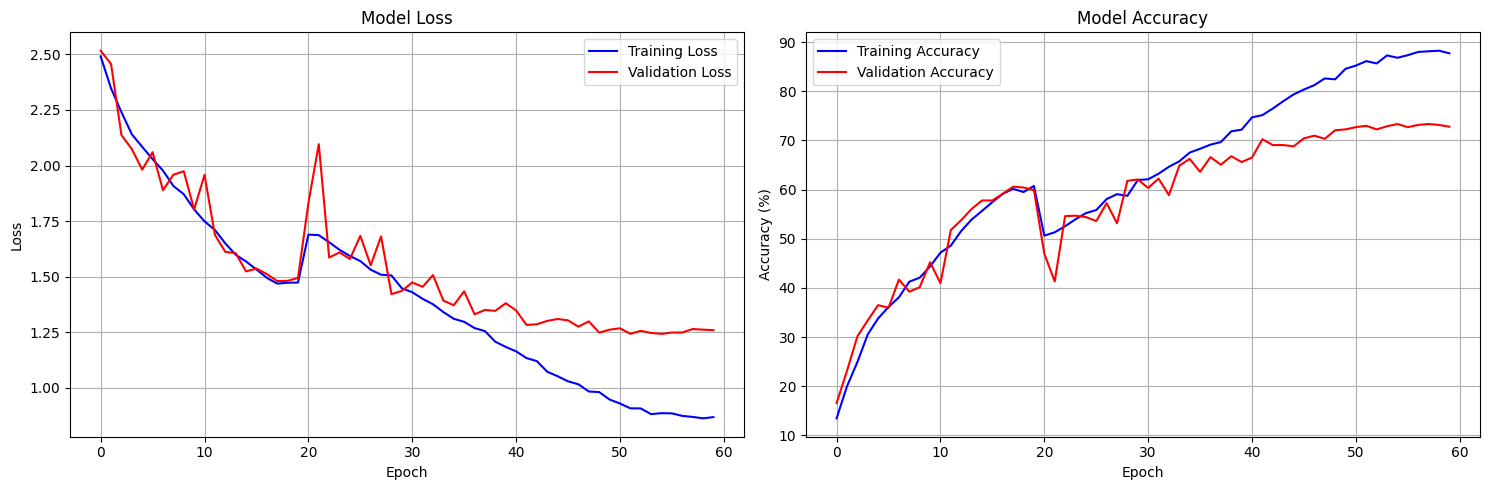

Evaluating: 100%|██████████| 35/35 [00:01<00:00, 18.28it/s]


Test Accuracy: 73.34%

Classification Report:
              precision    recall  f1-score   support

        ants       0.78      0.80      0.79       100
        bees       0.77      0.86      0.82       100
      beetle       0.56      0.43      0.49        83
catterpillar       0.60      0.46      0.52        87
  earthworms       0.46      0.55      0.50        65
      earwig       0.66      0.56      0.60        93
 grasshopper       0.69      0.67      0.68        97
        moth       0.87      0.92      0.89        99
        slug       0.49      0.47      0.48        78
       snail       0.91      0.94      0.93       100
        wasp       0.87      0.96      0.91       100
      weevil       0.85      0.96      0.90        97

    accuracy                           0.73      1099
   macro avg       0.71      0.72      0.71      1099
weighted avg       0.73      0.73      0.73      1099



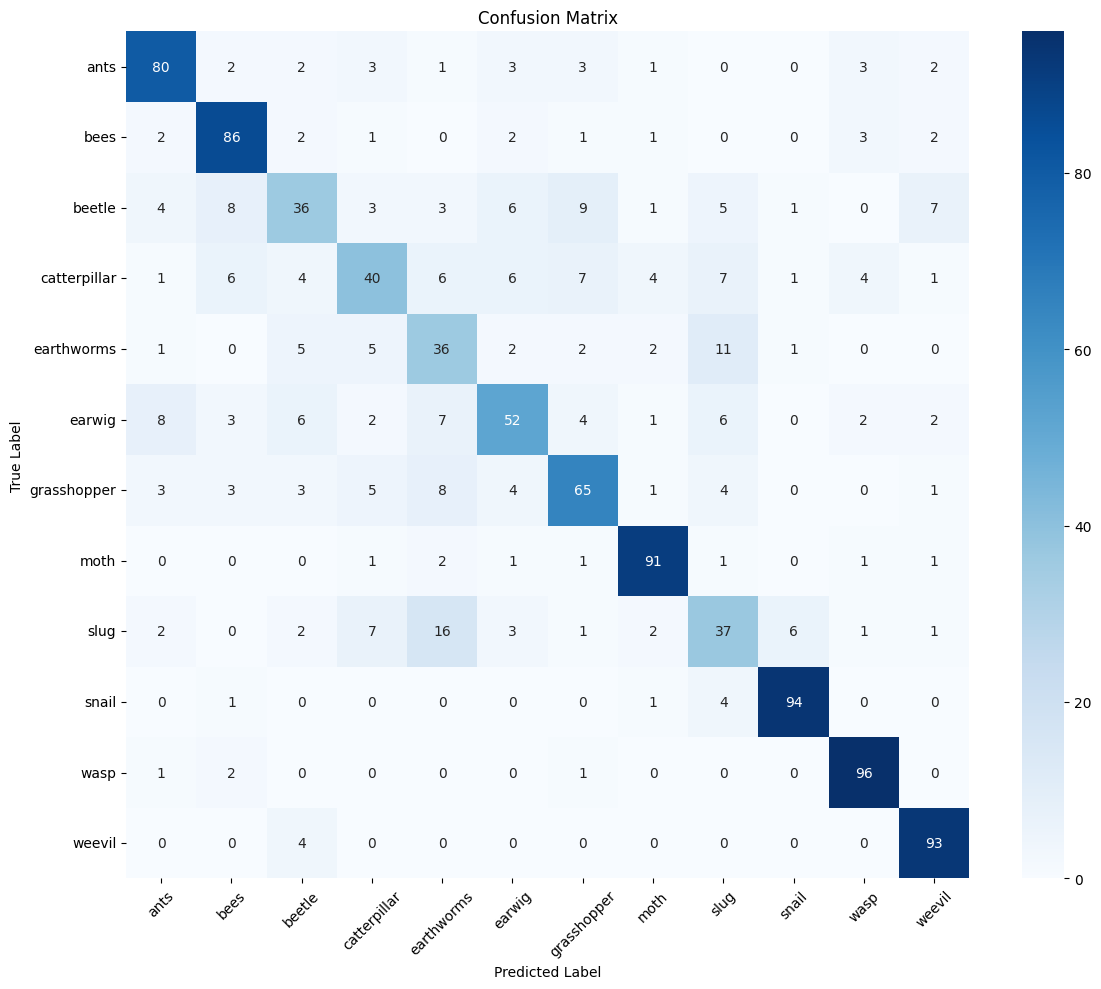

Layer (type:depth-idx)                   Output Shape              Param #
CustomModel                              [1, 12]                   --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 112, 112]         64
│    └─ReLU6: 2-3                        [1, 32, 112, 112]         --
├─Sequential: 1-2                        [1, 320, 7, 7]            --
│    └─InvertedResidual: 2-4             [1, 16, 112, 112]         --
│    │    └─Sequential: 3-1              [1, 16, 112, 112]         896
│    └─InvertedResidual: 2-5             [1, 24, 56, 56]           --
│    │    └─Sequential: 3-2              [1, 24, 56, 56]           5,136
│    └─InvertedResidual: 2-6             [1, 24, 56, 56]           --
│    │    └─Sequential: 3-3              [1, 24, 56, 56]           8,832
│    └─InvertedResidual: 2-7             [1, 32, 28, 28]           --
│    │ 

In [38]:
# Model Evaluation and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(history['train_losses'], label='Training Loss', color='blue')
    ax1.plot(history['val_losses'], label='Validation Loss', color='red')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(history['train_accuracies'], label='Training Accuracy', color='blue')
    ax2.plot(history['val_accuracies'], label='Validation Accuracy', color='red')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, class_names):
    """Comprehensive model evaluation"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100. * sum(np.array(all_predictions) == np.array(all_targets)) / len(all_targets)
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    # Classification report
    print('\nClassification Report:')
    print(classification_report(all_targets, all_predictions, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_predictions, all_targets

# Load best model for evaluation
checkpoint = torch.load('best_light_mobilenet_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Get class names
class_names = sorted(train_data['label'].unique())

# Plot training history
plot_training_history(training_history)

# Evaluate model
test_accuracy, predictions, targets = evaluate_model(model, val_loader, class_names)


from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224))